/home/alexmak123/yesno/yes
'yes1.png?raw=true'  'yes3.png?raw=true'  'yes5.png?raw=true'
'yes2.png?raw=true'  'yes4.png?raw=true'
(5, 512, 512, 3)
/home/alexmak123/yesno


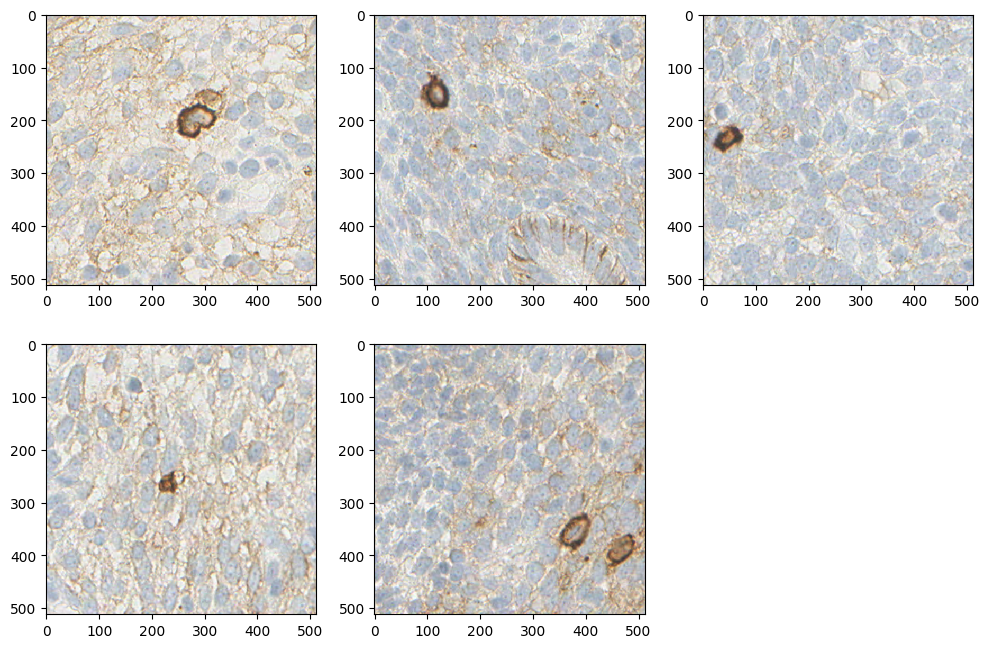

In [1]:
#uploading our plasmatic cells
import argparse
import json
import os
from animus.torch.engine import CPUEngine, DDPEngine, DPEngine, GPUEngine, XLAEngine
from neurone.utils.general import load_yaml
import torch
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image, ImageDraw
from skimage.io import imread, imsave, imshow
import cv2
%matplotlib inline


plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
alb_transforms = A.Compose([A.augmentations.Resize(512, 512)])


#Download our tile
%cd ../yesno/yes
%ls 
directory_in_str = "/home/alexmak123/yesno/yes"

def import_tiles_from_directory_and_convert_them (directory_in_str):
    directory = os.fsencode(directory_in_str)
    i = 1
    converted_images = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith("?raw=true"): 
            myTile = np.array(Image.open(filename).convert('RGB'))
            myTile = alb_transforms(image=myTile)["image"]
            plt.subplot(3, 3, i)
            imshow(myTile)
            converted_images.append(myTile)
            i += 1
            continue
        else:
            continue
    return np.array(converted_images)

converted_images = import_tiles_from_directory_and_convert_them (directory_in_str)
print (converted_images.shape)
%cd ../

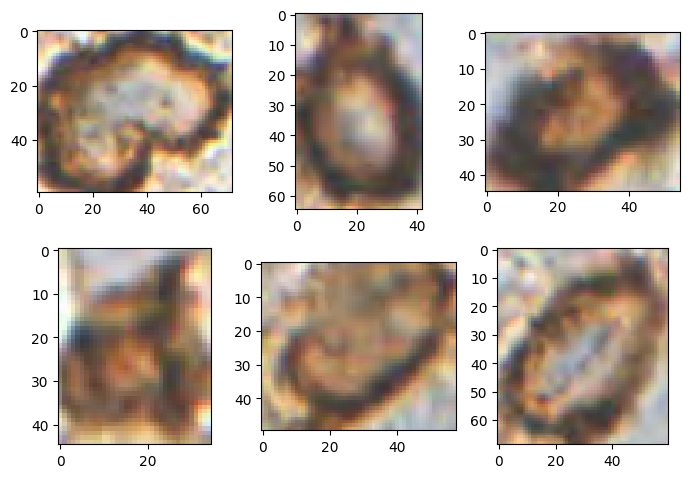

In [2]:
#select the areas, where the plasmatic cells are detected
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True

brown_cells = []

brown_cells.append(converted_images[0][170:230, 250:322])
brown_cells.append(converted_images[1][115:180, 98:140])
brown_cells.append(converted_images[2][210:255, 20:75])
brown_cells.append(converted_images[3][240:285, 213:248])
brown_cells.append(converted_images[4][370:420, 435:493])
brown_cells.append(converted_images[4][318:387, 350:410])

for i in range(len(brown_cells)):
    plt.subplot(3, 3, i+1)
    imshow(brown_cells[i])

In result we have converted_images[], that represents our tiles and brown_cells[], that represents plasmatic cells in these tiles


Let's apply different filters and see how our images change

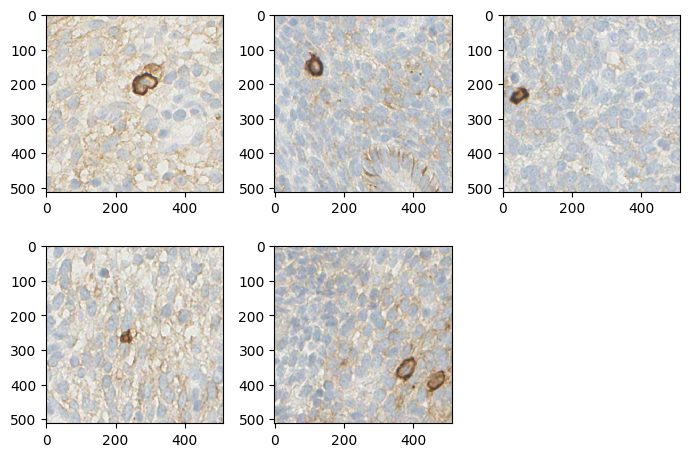

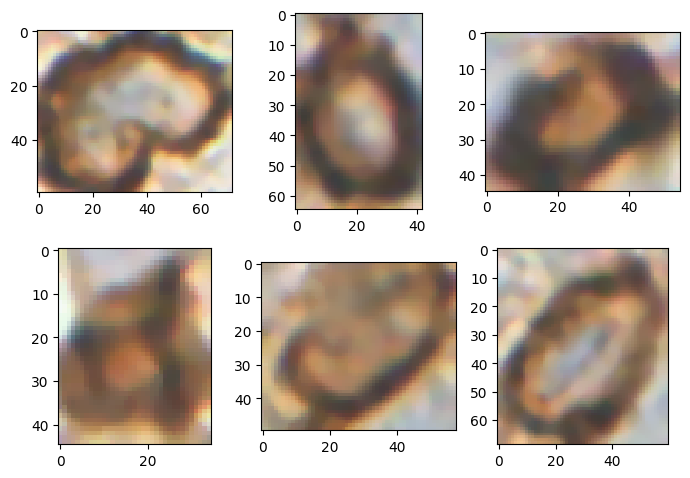

In [7]:
#median filter 5x5

median_filter_size = 5

def median_filter (images_list, size):
    for i in range(len(images_list)):
        median_image  = cv2.medianBlur(images_list[i], size)
        plt.subplot(3, 3, i+1)
        imshow(median_image)
    
    plt.show()

median_filter (converted_images, median_filter_size)
median_filter (brown_cells, median_filter_size)

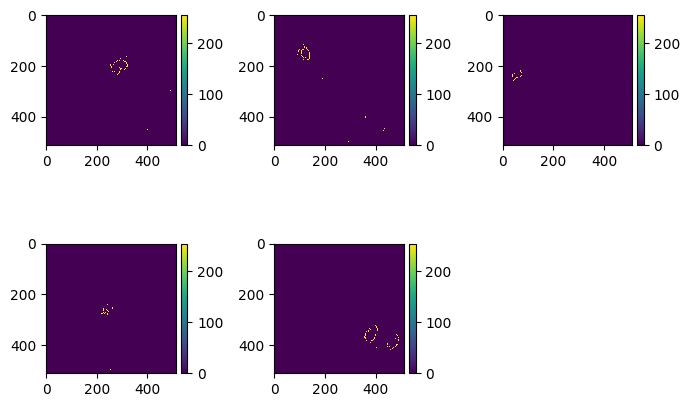

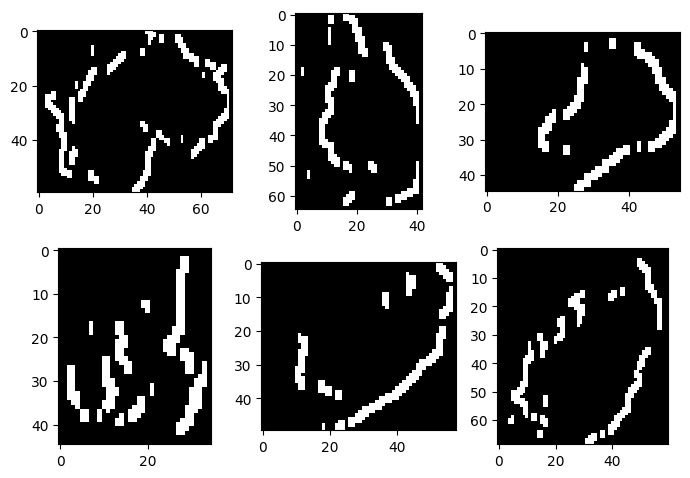

In [5]:
#Sobel filter
#Applies to BlackAndWhite Images

def Sobel_filter (images_list):
    for i in range(len(images_list)):
        
        img_grey = cv2.cvtColor(images_list[i],cv2.COLOR_BGR2GRAY)
        #get the image, cropped by the threshold
        (thresh, blackAndWhiteImage) = cv2.threshold(img_grey, 95, 255, cv2.THRESH_BINARY)
        kernel = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
        img = cv2.filter2D(blackAndWhiteImage, -1, kernel)
    
        plt.subplot(3, 3, i+1)
        imshow(img, vmin=0, vmax=255)
    
    plt.show()

Sobel_filter (converted_images)
Sobel_filter (brown_cells)

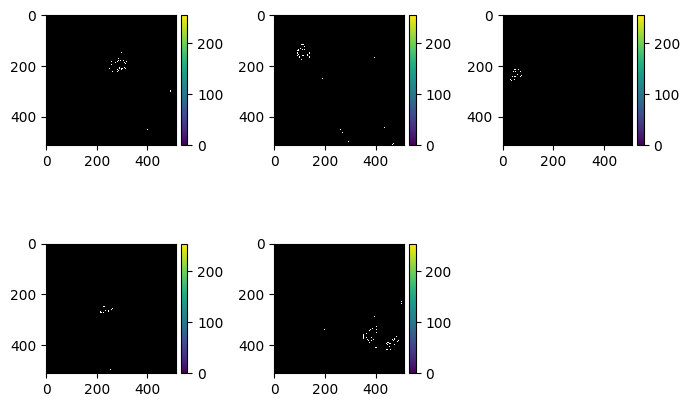

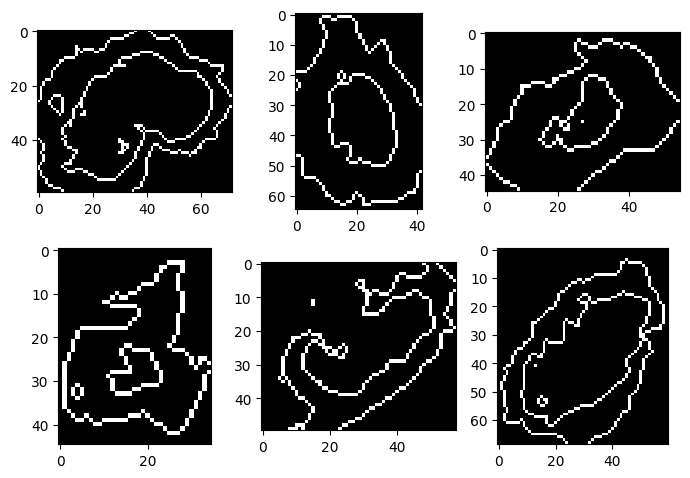

In [17]:
#Laplacian filter 
#Applies to BlackAndWhite Images
#Counts Сontours precisely

def Laplacian_filter (images_list):
    for i in range(len(images_list)):
        
        img_grey = cv2.cvtColor(images_list[i],cv2.COLOR_BGR2GRAY)
        #get the image, cropped by the threshold
        (thresh, blackAndWhiteImage) = cv2.threshold(img_grey, 108, 255, cv2.THRESH_BINARY)
        kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]])
        img = cv2.filter2D(blackAndWhiteImage, -1, kernel)
        
        contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        img_contours = np.zeros(images_list[i].shape)
        cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
        
        plt.subplot(3, 3, i+1)
        imshow(img_contours.astype('uint8'), vmin=0, vmax=255)
    
    plt.show()

Laplacian_filter (converted_images)
Laplacian_filter (brown_cells)

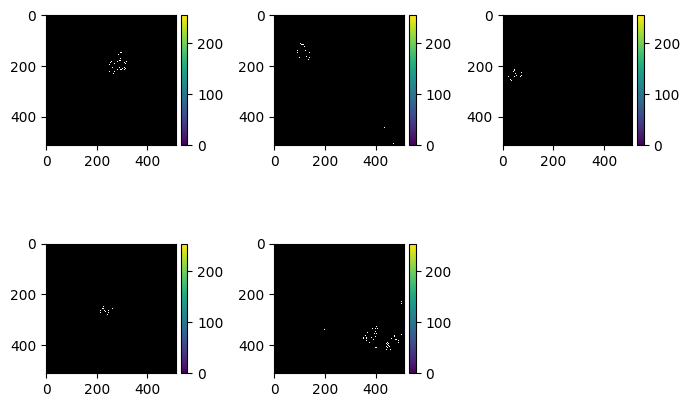

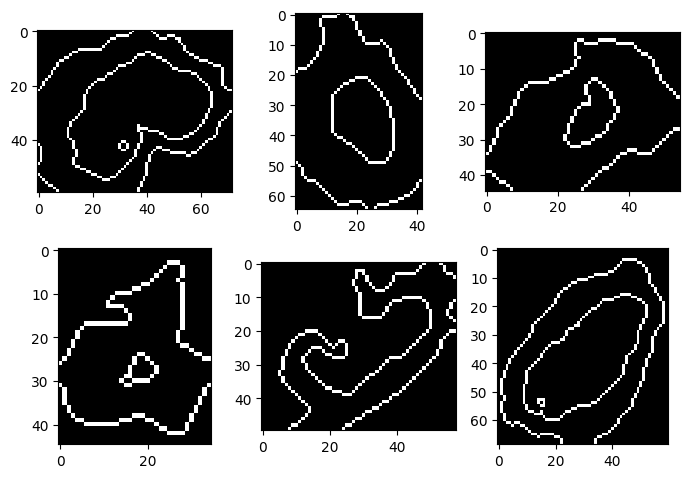

In [28]:
#Now let's apply Laplacian filter to images, that have been pre-processed by the median filter

def median_and_laplacian_filter (images_list, median_filter_size):
    for i in range(len(images_list)):
        
        median_image  = cv2.medianBlur(images_list[i], median_filter_size)
        
        img_grey = cv2.cvtColor(median_image, cv2.COLOR_BGR2GRAY)
        #get the image, cropped by the threshold
        (thresh, blackAndWhiteImage) = cv2.threshold(img_grey, 115, 255, cv2.THRESH_BINARY)
        kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]])
        img = cv2.filter2D(blackAndWhiteImage, -1, kernel)
        
        contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        img_contours = np.zeros(images_list[i].shape)
        cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
        
        plt.subplot(3, 3, i+1)
        imshow(img_contours.astype('uint8'), vmin=0, vmax=255)
    
    plt.show()

    
median_filter_size = 5    
    
median_and_laplacian_filter (converted_images, median_filter_size)
median_and_laplacian_filter (brown_cells, median_filter_size)

We can see that the results are very precise. Next step is to count meanstd of brown color and aply this filter to the 
whole slide, using meanstd threshold